In [16]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from random import shuffle
import matplotlib.pyplot as plt
import time
import copy
from random import shuffle
import tensorflow as tf


import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, models, transforms
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
from torchvision.io import read_image
from torchvision.utils import save_image

import tqdm.notebook as tqdm

import sklearn
from sklearn.metrics import accuracy_score, cohen_kappa_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay,classification_report
from sklearn.metrics import roc_curve, auc, roc_auc_score
from PIL import Image
import cv2

import os
import shutil

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [17]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # create device

In [56]:
TRAIN_PATH='/kaggle/input/ismdata/ISM_2022w/train'
TEST_PATH='/kaggle/input/ismdata/ISM_2022w/test'
NOISY_TEST='/kaggle/input/ismdata/ISM_2022w/noisy_test'

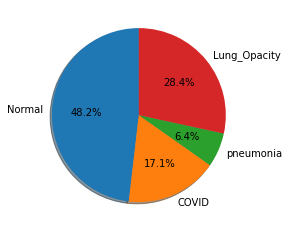

In [19]:
TRAIN_TXT_FP = '/kaggle/input/ismdata/ISM_2022w/train.txt'
image_count = {}
data_frame = pd.read_csv(TRAIN_TXT_FP, sep = ' ', names =['img_name', 'data_labels', ])
# data_frame.head(10000)

#Getting the count of each label
image_count['Normal'] = len(data_frame[data_frame['data_labels'] == 'Normal'])
image_count['COVID'] = len(data_frame[data_frame['data_labels'] == 'COVID'])
image_count['pneumonia'] = len(data_frame[data_frame['data_labels'] == 'pneumonia'])
image_count['Lung_Opacity'] = len(data_frame[data_frame['data_labels'] == 'Lung_Opacity'])

fig1, ax1 = plt.subplots()
ax1.pie(image_count.values(),
        labels = image_count.keys(),
        shadow=True,
        autopct = '%1.1f%%',
        startangle=90)
plt.show()

In [20]:
Normal_df = data_frame[(data_frame.data_labels=="Normal")]
Covid_df=data_frame[(data_frame.data_labels=="COVID")]
Pnemonia_df=data_frame[(data_frame.data_labels=="pneumonia")]
Lung_Opacity_df=data_frame[(data_frame.data_labels=="Lung_Opacity")]

In [21]:
os.makedirs('./COVID19-DATASET/train/covid19')
os.makedirs('./COVID19-DATASET/train/normal')
os.makedirs('./COVID19-DATASET/train/pneu')
os.makedirs('./COVID19-DATASET/train/lung')

In [22]:
COVID_PATH = './COVID19-DATASET/train/covid19'
NORMAL_PATH = './COVID19-DATASET/train/normal'
PNEU_PATH = './COVID19-DATASET/train/pneu'
LUNG_PATH = './COVID19-DATASET/train/lung'

In [23]:
Normal_img=Normal_df.img_name.values.tolist()
Covid_img=Covid_df.img_name.values.tolist()
Pneu_img=Pnemonia_df.img_name.values.tolist()
Lung_img=Lung_Opacity_df.img_name.values.tolist()
for image in Normal_img:
    shutil.copy(os.path.join(TRAIN_PATH, image), os.path.join(NORMAL_PATH, image))
for image in Covid_img:
    shutil.copy(os.path.join(TRAIN_PATH, image), os.path.join(COVID_PATH, image))
for image in Pneu_img:
    shutil.copy(os.path.join(TRAIN_PATH, image), os.path.join(PNEU_PATH, image))
for image in Lung_img:
    shutil.copy(os.path.join(TRAIN_PATH, image), os.path.join(LUNG_PATH, image))

In [24]:
imageHeight = 230
imageWidth = 230
modelImgSize = 224

# number of subprocesses to use for data loading
num_workers = 0
# how many samples per batch to load
batch_size = 16
# percentage of training set to use as validation
valid_size = 0.2



In [25]:
DATA_PATH = './COVID19-DATASET/train'

In [26]:
#Statistics Based on ImageNet Data for Normalisation
mean_nums = [0.485, 0.456, 0.406]
std_nums = [0.229, 0.224, 0.225]

data_transforms = {"train":transforms.Compose([
                                        transforms.Resize((imageHeight,imageWidth)),
                                        transforms.CenterCrop(modelImgSize),
                                        transforms.RandomApply([transforms.RandomRotation(90)], p =0.1),
                                        transforms.RandomHorizontalFlip(p=0.1),
                                        transforms.RandomVerticalFlip(p=0.1),
                                        transforms.ToTensor(),
                                        transforms.Normalize(mean = mean_nums, std=std_nums)
                                        ]), # Normalizes
                    "val": transforms.Compose([
                                               transforms.Resize((imageHeight,imageWidth)),
                                               transforms.CenterCrop(modelImgSize),
                                               transforms.ToTensor(),
                                               transforms.Normalize(mean=mean_nums, std = std_nums)
                    ])}

In [27]:
def load_split_train_test(datadir, valid_size = .2):
    train_data = datasets.ImageFolder(datadir,       
                    transform=data_transforms['train']) #Picks up Image Paths from its respective folders and label them
    test_data = datasets.ImageFolder(datadir,
                    transform=data_transforms['val'])
    num_train = len(train_data)
    print(num_train)
    num_train = len(train_data)
    indices = list(range(num_train))
    
    split = int(np.floor(valid_size * num_train))
    np.random.shuffle(indices)
    train_idx, test_idx = indices[split:], indices[:split]
    dataset_size = {"train":len(train_idx), "val":len(test_idx)}
    print(dataset_size)
    train_sampler = SubsetRandomSampler(train_idx) # Sampler for splitting train and val images
    test_sampler = SubsetRandomSampler(test_idx)
    trainloader = torch.utils.data.DataLoader(train_data,
                   sampler=train_sampler, batch_size=16,num_workers=num_workers,pin_memory=True) # DataLoader provides data from traininng and validation in batches
    testloader = torch.utils.data.DataLoader(test_data,
                   sampler=test_sampler, batch_size=16,num_workers=num_workers,pin_memory=True)
   
    return trainloader, testloader, dataset_size
trainloader, valloader, dataset_size = load_split_train_test(DATA_PATH, .2)
dataloaders = {"train":trainloader, "val":valloader}
data_sizes = {x: len(dataloaders[x].sampler) for x in ['train','val']}
class_names = trainloader.dataset.classes
print(class_names)


16930
{'train': 13544, 'val': 3386}
['covid19', 'lung', 'normal', 'pneu']


Training Images


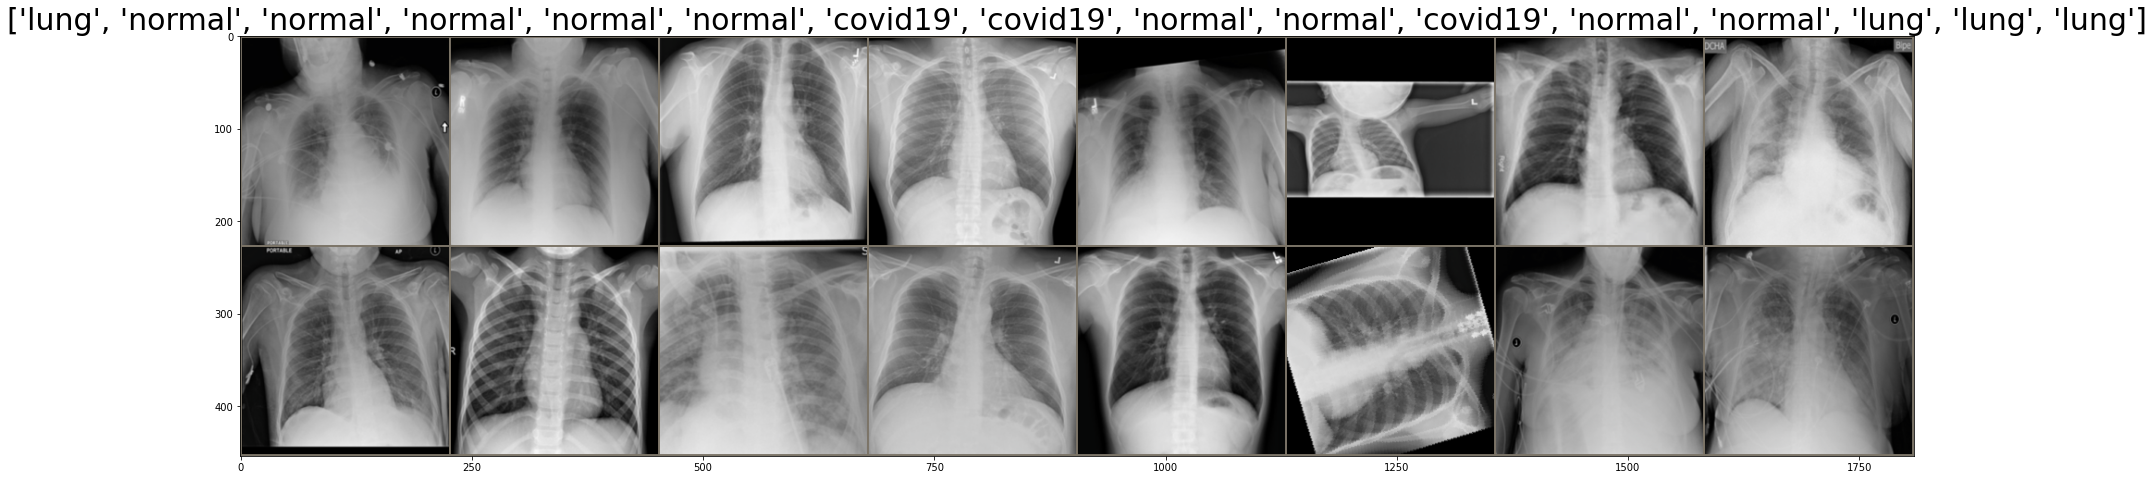

Validation Images


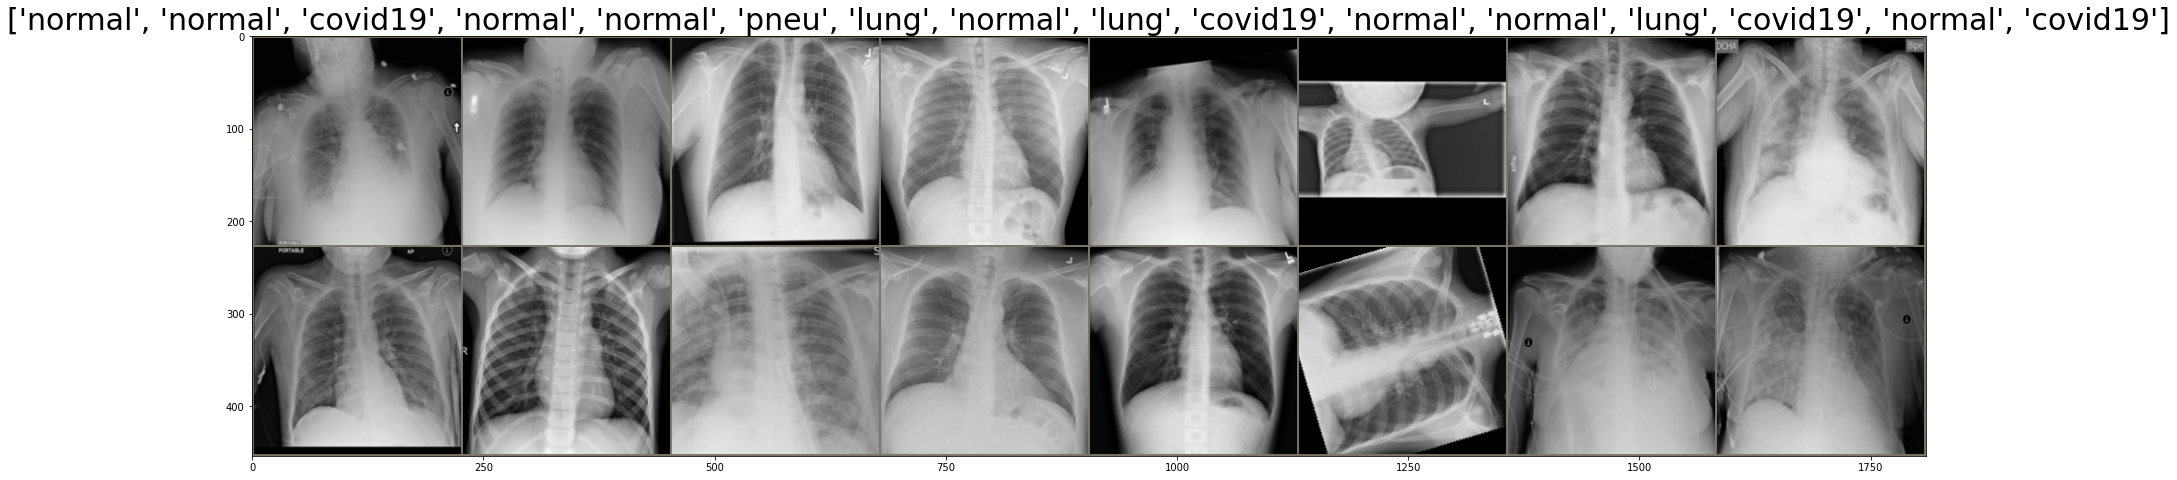

In [28]:
def imshow(inp, size =(30,30), title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = mean_nums
    std = std_nums
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.figure(figsize=size)
    plt.imshow(inp)
    if title is not None:
        plt.title(title, size=30)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
traininputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(traininputs)
print("Training Images")
imshow(out, title=[class_names[x] for x in classes])

# Get a batch of training data
valinputs, classes = next(iter(dataloaders['val']))
valout = torchvision.utils.make_grid(traininputs)
print("Validation Images")
imshow(valout, title=[class_names[x] for x in classes])


In [29]:
if torch.cuda.is_available():
    device=torch.device("cuda:0")
    print("Training on GPU")
else:
    device = torch.device("tpu")
    print("Training ontttPU")

Training on GPU


In [30]:
torch.cuda.empty_cache()

https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html

https://www.kaggle.com/code/arunrk7/covid-19-detection-pytorch-tutorial

In [31]:
def CNN_Model(pretrained=True):
    model = torchvision.models.densenet121(pretrained=pretrained) # Returns Defined Densenet model with weights trained on ImageNet
    num_ftrs = model.classifier.in_features 
    print(num_ftrs)# Get the number of features output from CNN layer
    model.classifier = nn.Linear(num_ftrs, len(class_names)) # Overwrites the Classifier layer with custom defined layer for transfer learning
    model = model.to(device) # Transfer the Model to GPU if available
    return model

model = CNN_Model(pretrained=True)
print(model) 

# specify loss function (categorical cross-entropy loss)
criterion = nn.CrossEntropyLoss() 

#optimizer = torch.optim.Adam(model.parameters(), lr=learningRate)
optimizer = optim.Adam (model.parameters(), lr=1e-3, betas=(0.9, 0.999), eps=1e-08, weight_decay=1e-5)

# Learning Rate scheduler
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor = 0.1, patience = 3, mode = 'min')

Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth


  0%|          | 0.00/30.8M [00:00<?, ?B/s]

1024
DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        

In [32]:
#Empty Lists 
train_loss = []
train_acc = []
epoch_counter_train = []
epoch_counter_val=[]
val_loss=[]
val_acc=[]
num_epochs=20
stopped_epoch=0

In [33]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=10):
    since = time.time()



    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = np.inf
    
    for epoch in range(num_epochs):
            print('Epoch {}/{}'.format(epoch+1, num_epochs))
            print('-' * 10)
            #epochList.append(epoch+1)
            # Each epoch has a training and validation phase
            for phase in ['train', 'val']:
                if phase == 'train':
                    model.train()  # Set model to training mode
                else:
                    model.eval()   # Set model to evaluate mode

                current_loss = 0.0
                current_corrects = 0

                for inputs, labels in tqdm.tqdm(dataloaders[phase], desc=phase, leave=False):
                    inputs = inputs.to(device)
                    labels = labels.to(device)

                    # We need to zero the gradients in the Cache.
                    optimizer.zero_grad()

                    # Time to carry out the forward training poss
                    # We only need to log the loss stats if we are in training phase
                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)

                        # backward + optimize only if in training phase
                        if phase == 'train':
                            loss.backward()
                            optimizer.step()
              
                

                    # We want variables to hold the loss statistics
                    current_loss += loss.item() * inputs.size(0)
                    current_corrects += torch.sum(preds == labels.data)


                epoch_loss = current_loss / data_sizes[phase]
                epoch_acc = current_corrects.double() / data_sizes[phase]
                if phase == 'val':
                    scheduler.step(epoch_loss)
                    val_loss.append(current_loss/ data_sizes[phase])
                    val_acc.append(current_corrects.double() / data_sizes[phase])
                    epoch_counter_val.append(epoch)
                    print('{} Loss: {:.4f} | {} Accuracy: {:.4f}'.format(
                        phase, epoch_loss, phase, epoch_acc))

                else:
                    train_loss.append(current_loss/data_sizes[phase])
                    train_acc.append(current_corrects.double() / data_sizes[phase])
                    epoch_counter_train.append(epoch)
                    print('{} Loss: {:.4f} | {} Accuracy: {:.4f}'.format(
                        phase, epoch_loss, phase, epoch_acc))
                      # EARLY STOPPING
                if phase == 'val' and epoch_loss < best_loss:
                    print('Val loss Decreased from {:.4f} to {:.4f} \nSaving Weights... '.format(best_loss, epoch_loss))
                    best_loss = epoch_loss  
                    stopped_epoch=epoch+1
                            
                    best_model_wts = copy.deepcopy(model.state_dict())

            
    time_since = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
            time_since // 60, time_since % 60))
    print('Best val loss: {:.4f}'.format(best_loss))



        # Now we'll load in the best model weights and return it
        #model.load_state_dict(best_model_wts)torch.save(model.load_state_dict(best_model_wts), '/kaggle/working/'+'bestModel.pth')
    return model

In [34]:
pytorch_total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print("Number of trainable parameters: \n{}".format(pytorch_total_params))

Number of trainable parameters: 
6957956


In [35]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_handeled = 0
    ax = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)
           

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            print(preds)
           
            target = labels.data.cpu().numpy()
            print(target)

    
            for j in range(inputs.size()[0]):
                images_handeled += 1    
                ax = plt.subplot(num_images//2, 2, images_handeled)
                ax.axis('off')
                ax.set_title('Actual: {} predicted: {}'.format(class_names[labels[j].item()],class_names[preds[j]]))
                imshow(inputs.cpu().data[j], (5,5))
               

                if images_handeled == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [36]:
base_model = train_model(model, criterion, optimizer, scheduler, num_epochs=20)

Epoch 1/20
----------


train:   0%|          | 0/847 [00:00<?, ?it/s]

train Loss: 0.5358 | train Accuracy: 0.7977


val:   0%|          | 0/212 [00:00<?, ?it/s]

val Loss: 0.5518 | val Accuracy: 0.7989
Val loss Decreased from inf to 0.5518 
Saving Weights... 
Epoch 2/20
----------


train:   0%|          | 0/847 [00:00<?, ?it/s]

train Loss: 0.3911 | train Accuracy: 0.8578


val:   0%|          | 0/212 [00:00<?, ?it/s]

val Loss: 0.4090 | val Accuracy: 0.8609
Val loss Decreased from 0.5518 to 0.4090 
Saving Weights... 
Epoch 3/20
----------


train:   0%|          | 0/847 [00:00<?, ?it/s]

train Loss: 0.3402 | train Accuracy: 0.8754


val:   0%|          | 0/212 [00:00<?, ?it/s]

val Loss: 0.3004 | val Accuracy: 0.8940
Val loss Decreased from 0.4090 to 0.3004 
Saving Weights... 
Epoch 4/20
----------


train:   0%|          | 0/847 [00:00<?, ?it/s]

train Loss: 0.3148 | train Accuracy: 0.8872


val:   0%|          | 0/212 [00:00<?, ?it/s]

val Loss: 0.2379 | val Accuracy: 0.9176
Val loss Decreased from 0.3004 to 0.2379 
Saving Weights... 
Epoch 5/20
----------


train:   0%|          | 0/847 [00:00<?, ?it/s]

train Loss: 0.2938 | train Accuracy: 0.8912


val:   0%|          | 0/212 [00:00<?, ?it/s]

val Loss: 0.2071 | val Accuracy: 0.9309
Val loss Decreased from 0.2379 to 0.2071 
Saving Weights... 
Epoch 6/20
----------


train:   0%|          | 0/847 [00:00<?, ?it/s]

train Loss: 0.2737 | train Accuracy: 0.9008


val:   0%|          | 0/212 [00:00<?, ?it/s]

val Loss: 0.2404 | val Accuracy: 0.9188
Epoch 7/20
----------


train:   0%|          | 0/847 [00:00<?, ?it/s]

train Loss: 0.2599 | train Accuracy: 0.9087


val:   0%|          | 0/212 [00:00<?, ?it/s]

val Loss: 0.2342 | val Accuracy: 0.9185
Epoch 8/20
----------


train:   0%|          | 0/847 [00:00<?, ?it/s]

train Loss: 0.2453 | train Accuracy: 0.9104


val:   0%|          | 0/212 [00:00<?, ?it/s]

val Loss: 0.2291 | val Accuracy: 0.9209
Epoch 9/20
----------


train:   0%|          | 0/847 [00:00<?, ?it/s]

train Loss: 0.2434 | train Accuracy: 0.9120


val:   0%|          | 0/212 [00:00<?, ?it/s]

val Loss: 0.2030 | val Accuracy: 0.9291
Val loss Decreased from 0.2071 to 0.2030 
Saving Weights... 
Epoch 10/20
----------


train:   0%|          | 0/847 [00:00<?, ?it/s]

train Loss: 0.2285 | train Accuracy: 0.9175


val:   0%|          | 0/212 [00:00<?, ?it/s]

val Loss: 0.1917 | val Accuracy: 0.9368
Val loss Decreased from 0.2030 to 0.1917 
Saving Weights... 
Epoch 11/20
----------


train:   0%|          | 0/847 [00:00<?, ?it/s]

train Loss: 0.2186 | train Accuracy: 0.9224


val:   0%|          | 0/212 [00:00<?, ?it/s]

val Loss: 0.2090 | val Accuracy: 0.9262
Epoch 12/20
----------


train:   0%|          | 0/847 [00:00<?, ?it/s]

train Loss: 0.2090 | train Accuracy: 0.9257


val:   0%|          | 0/212 [00:00<?, ?it/s]

val Loss: 0.1799 | val Accuracy: 0.9445
Val loss Decreased from 0.1917 to 0.1799 
Saving Weights... 
Epoch 13/20
----------


train:   0%|          | 0/847 [00:00<?, ?it/s]

train Loss: 0.1992 | train Accuracy: 0.9273


val:   0%|          | 0/212 [00:00<?, ?it/s]

val Loss: 0.2750 | val Accuracy: 0.8975
Epoch 14/20
----------


train:   0%|          | 0/847 [00:00<?, ?it/s]

train Loss: 0.1975 | train Accuracy: 0.9279


val:   0%|          | 0/212 [00:00<?, ?it/s]

val Loss: 0.1882 | val Accuracy: 0.9374
Epoch 15/20
----------


train:   0%|          | 0/847 [00:00<?, ?it/s]

train Loss: 0.1852 | train Accuracy: 0.9338


val:   0%|          | 0/212 [00:00<?, ?it/s]

val Loss: 0.1701 | val Accuracy: 0.9442
Val loss Decreased from 0.1799 to 0.1701 
Saving Weights... 
Epoch 16/20
----------


train:   0%|          | 0/847 [00:00<?, ?it/s]

train Loss: 0.1826 | train Accuracy: 0.9362


val:   0%|          | 0/212 [00:00<?, ?it/s]

val Loss: 0.1957 | val Accuracy: 0.9338
Epoch 17/20
----------


train:   0%|          | 0/847 [00:00<?, ?it/s]

train Loss: 0.1687 | train Accuracy: 0.9376


val:   0%|          | 0/212 [00:00<?, ?it/s]

val Loss: 0.2239 | val Accuracy: 0.9327
Epoch 18/20
----------


train:   0%|          | 0/847 [00:00<?, ?it/s]

train Loss: 0.1663 | train Accuracy: 0.9404


val:   0%|          | 0/212 [00:00<?, ?it/s]

val Loss: 0.1682 | val Accuracy: 0.9457
Val loss Decreased from 0.1701 to 0.1682 
Saving Weights... 
Epoch 19/20
----------


train:   0%|          | 0/847 [00:00<?, ?it/s]

train Loss: 0.1616 | train Accuracy: 0.9433


val:   0%|          | 0/212 [00:00<?, ?it/s]

val Loss: 0.1756 | val Accuracy: 0.9400
Epoch 20/20
----------


train:   0%|          | 0/847 [00:00<?, ?it/s]

train Loss: 0.1531 | train Accuracy: 0.9457


val:   0%|          | 0/212 [00:00<?, ?it/s]

val Loss: 0.1692 | val Accuracy: 0.9442
Training complete in 94m 30s
Best val loss: 0.1682


[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19] [0.5357910902434668, 0.39105524122274915, 0.3401704816223599, 0.31478780099645703, 0.2938267633987825, 0.2736976244297083, 0.2598558860730294, 0.24529357154826686, 0.24341737164533217, 0.22853172912630398, 0.21858231709335973, 0.20897129663347105, 0.19916966576206213, 0.1975385418119942, 0.18524444262275436, 0.18255138242748173, 0.1687075907652741, 0.1663325852849254, 0.16162711120723833, 0.15312995444774205]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19] [0.5518139333360236, 0.40895541581752665, 0.30039125835832164, 0.23792065781685845, 0.20713648788864206, 0.2404445227404987, 0.23422681050440017, 0.22912561298802944, 0.20304207641981228, 0.1916955729833173, 0.20902750628345193, 0.17988732961164342, 0.2750314072223366, 0.18821513690428485, 0.1700939064415263, 0.19572079897243738, 0.22389402427989494, 0.1681631185451046, 0.1755849139064075, 0.1691689488246412]


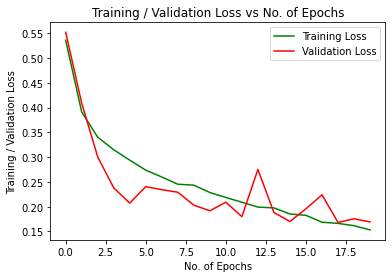

<Figure size 432x288 with 0 Axes>

In [37]:
print(epoch_counter_train, train_loss)
print(epoch_counter_val, val_loss)
plt.plot(epoch_counter_train, train_loss, 'g', label="Training Loss") 
plt.plot(epoch_counter_val, val_loss, 'r', label="Validation Loss")  
plt.title("Training / Validation Loss vs No. of Epochs")
plt.xlabel("No. of Epochs")
plt.ylabel("Training / Validation Loss")
plt.legend(loc="upper right")
#plt.axvline(x=stopped_epoch, color='k', linestyle='--') #Add Early Stopping Line
plt.show()
plt.savefig('Loss-vs-Epochs.png')

tensor([2, 3, 1, 2, 0, 1, 1, 2, 2, 2, 2, 2, 0, 0, 2, 1], device='cuda:0')
[2 3 1 2 0 1 1 2 2 2 2 2 0 0 2 1]


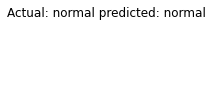

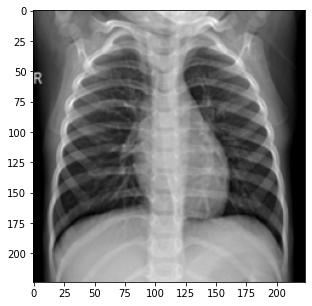

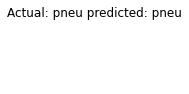

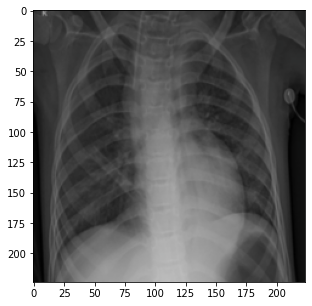

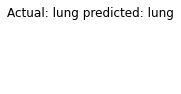

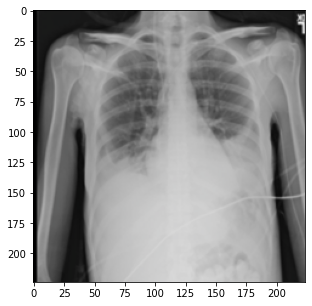

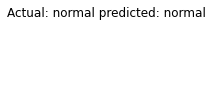

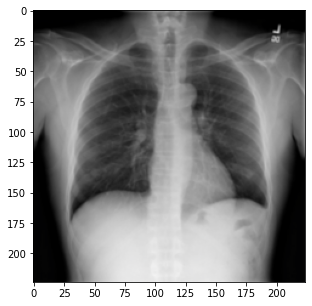

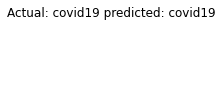

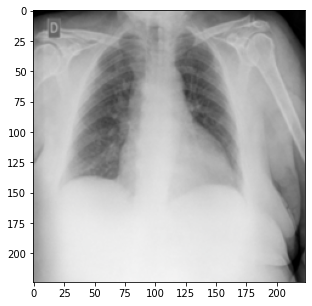

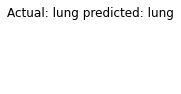

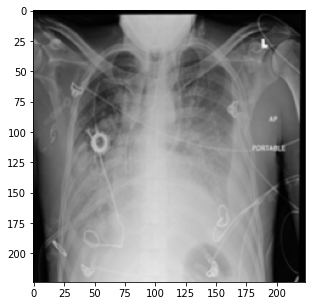

In [38]:
visualize_model(base_model)
plt.show()

In [39]:

y_pred_list = []
y_true_list = []
with torch.no_grad():
   
         for i,(x_batch, y_batch) in enumerate(valloader):
    
            x_batch = x_batch.to(device)
            y_batch= y_batch.to(device)
            y_test_pred = base_model(x_batch)
            y_test_pred = torch.log_softmax(y_test_pred, dim=1)
            _, y_pred_tag = torch.max(y_test_pred, dim = 1)
            y_pred_list.append(y_pred_tag.cpu().numpy())
            y_true_list.append(y_batch.cpu().numpy())

In [40]:
y_pred_list = [i[0]for i in y_pred_list]
y_true_list = [i[0] for i in y_true_list]

In [41]:
print(y_pred_list)

[1, 0, 1, 2, 2, 2, 0, 1, 0, 2, 1, 0, 1, 1, 2, 2, 1, 2, 0, 0, 1, 2, 2, 2, 2, 2, 1, 2, 0, 2, 1, 0, 2, 0, 0, 2, 0, 1, 1, 0, 0, 2, 3, 2, 2, 2, 2, 2, 1, 1, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 1, 2, 1, 1, 2, 1, 1, 2, 2, 2, 2, 3, 2, 1, 0, 0, 2, 2, 2, 2, 2, 2, 1, 1, 2, 2, 1, 1, 2, 2, 2, 3, 2, 1, 1, 0, 2, 2, 0, 2, 2, 1, 1, 2, 2, 1, 1, 2, 0, 1, 1, 1, 0, 2, 3, 0, 2, 2, 0, 2, 1, 3, 1, 2, 2, 1, 0, 2, 0, 2, 2, 0, 3, 1, 0, 2, 0, 2, 2, 1, 2, 2, 0, 1, 2, 2, 0, 3, 1, 3, 2, 2, 2, 2, 1, 2, 0, 2, 2, 0, 2, 2, 1, 2, 0, 1, 1, 2, 2, 2, 1, 2, 2, 1, 0, 2, 3, 2, 2, 2, 3, 2, 0, 0, 2, 2, 0, 2, 1, 0, 1, 2, 2, 3, 1, 2, 2, 2, 2, 2, 0, 0, 3, 2, 2]


In [42]:
print(classification_report(y_true_list, y_pred_list))

              precision    recall  f1-score   support

           0       0.89      1.00      0.94        34
           1       0.91      0.89      0.90        55
           2       0.96      0.94      0.95       111
           3       1.00      1.00      1.00        12

    accuracy                           0.94       212
   macro avg       0.94      0.96      0.95       212
weighted avg       0.94      0.94      0.94       212



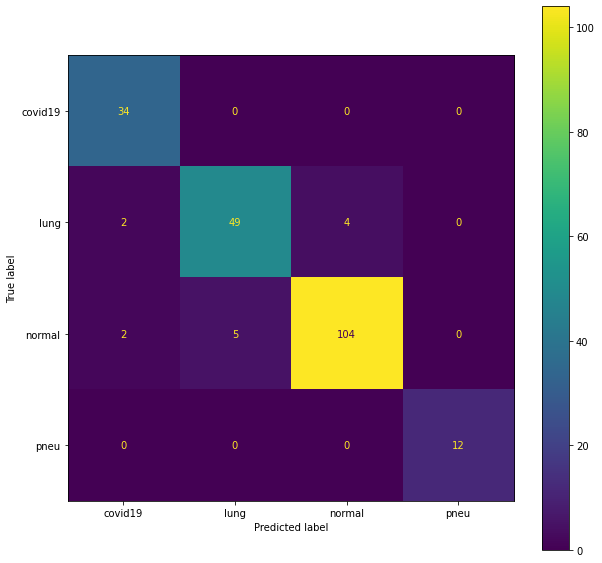

<Figure size 432x288 with 0 Axes>

In [43]:

    classLabels = ['covid19', 'lung', 'normal', 'pneu']
    confMat = confusion_matrix(y_true_list,y_pred_list)
    dispConfMat = ConfusionMatrixDisplay(confusion_matrix = confMat, display_labels = np.asarray(classLabels))
    fig, ax = plt.subplots(figsize=(10,10))
    dispConfMat.plot(ax=ax)
    plt.show()
    plt.savefig('Confusion Matrix.png')

tesing using noisy test data

In [57]:
imgCount = 0
testImages = []
testnoiseImages = []
for file in os.listdir(TEST_PATH):
    imgCount = imgCount + 1
    testImages.append(file)
print("Test Images : ",len(testImages))
imgCount = 0

for file in os.listdir(NOISY_TEST):
    imgCount = imgCount + 1
    testnoiseImages.append(file)
print("Test Noise Images : ",len(testnoiseImages))
testDF = pd.DataFrame(testImages)
testnoiseDF = pd.DataFrame(testnoiseImages)
testDF.to_csv('testImages.csv',index=False)
testnoiseDF.to_csv('testnoiseImages.csv',index=False)

Test Images :  4235
Test Noise Images :  4235


In [58]:
class CreateTestDataset(Dataset):
    def __init__(self, csv_file, img_dir, transform=None):
        self.img_name = pd.read_csv(csv_file)
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.img_name)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_name.iloc[idx,0])
        image = read_image(img_path)
        if self.transform:
            image = self.transform(image)
        return image, self.img_name.iloc[idx,0]

In [59]:


test_transforms = transforms.Compose([transforms.ToPILImage(),
                                      transforms.Resize((150,150)),
                                      transforms.ToTensor(),
                                      transforms.Normalize(mean=mean_nums, std=std_nums)
])


testDataset = CreateTestDataset(csv_file = '/kaggle/working/testImages.csv', img_dir = TEST_PATH, transform = test_transforms)
testDataloader = torch.utils.data.DataLoader(dataset = testDataset, batch_size = 8, shuffle = False,pin_memory=True)

testNoiseDataset = CreateTestDataset(csv_file = '/kaggle/working/testnoiseImages.csv', img_dir = NOISY_TEST, transform = test_transforms)
testNoiseDataloader = torch.utils.data.DataLoader(dataset = testNoiseDataset, batch_size = 8 ,shuffle = False,pin_memory=True)



Sample of Test Images


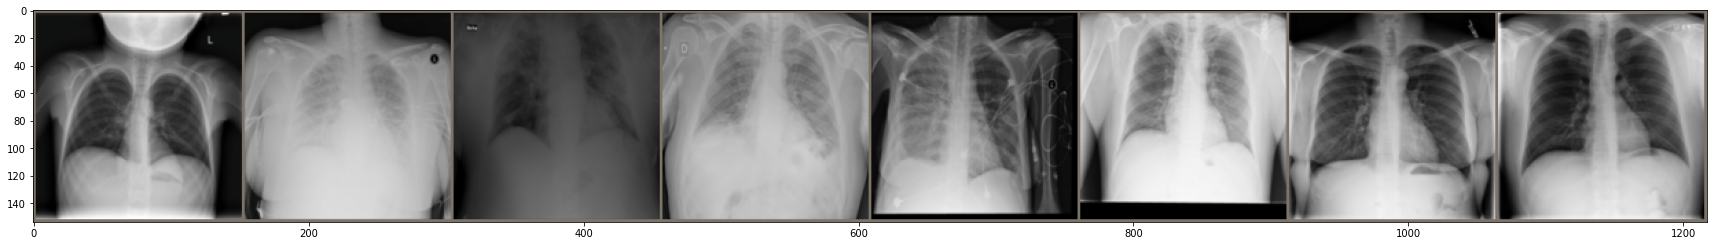

Sample of Test Noise Images


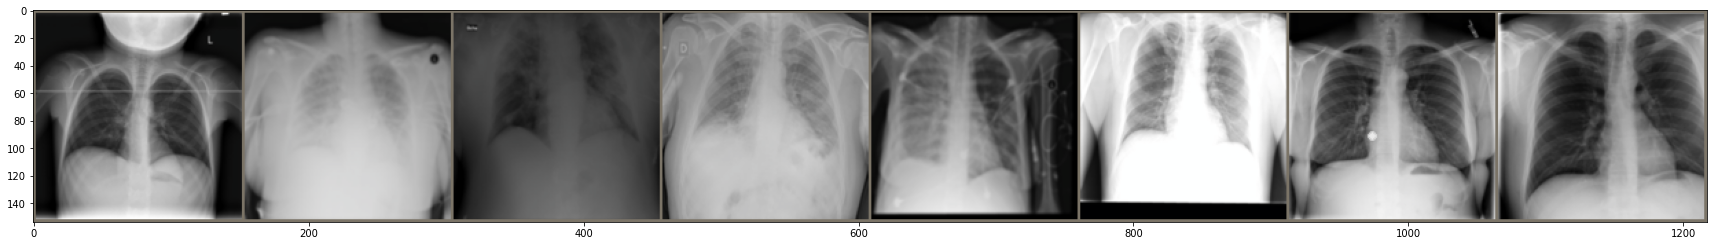

In [60]:
# Display Testing Data and verify if Test DataLoader works correctly

testInputs,_ = next(iter(testDataloader))
testGrid = torchvision.utils.make_grid(testInputs)
print("Sample of Test Images")
imshow(testGrid)

testnoiseInputs,_ = next(iter(testNoiseDataloader))
testnoiseGrid = torchvision.utils.make_grid(testnoiseInputs)
print("Sample of Test Noise Images")
imshow(testnoiseGrid)

[0, 2, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 1, 0, 2, 1, 0, 0, 0, 0, 0, 0, 3, 2, 0, 0, 2, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 2, 0, 0, 2, 3, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 2, 1, 2, 2, 1, 0, 0, 0, 0, 0, 2, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 2, 1, 0, 0, 0, 0, 2, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 2, 2, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 2, 1, 2, 0, 0, 0, 0, 3, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 2, 0, 3, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 2, 0, 0, 2, 0, 0, 2, 2, 0, 0, 0, 0, 3, 0, 0, 0, 1, 1, 0, 0, 0, 2, 0, 0, 0, 0, 2, 2, 0, 0, 2, 2, 2, 0, 1, 0, 0, 0, 0, 3, 0, 2, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 2, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 0, 0, 0, 1, 1, 0, 0, 2, 2, 0, 0, 0, 3, 2, 0, 0, 0, 0, 1, 0, 1, 0, 0, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 

In [61]:
## Getting Predictions for Test Sets

def test_function(model, device, dataLoader,covid=False):
    imgNames = []
    imageClass1 = []
    imageClass2 = []
    model.eval()

    with torch.no_grad():
        for i, (images,imageNameBatch) in enumerate(dataLoader):
            images = images.to(device)
            output = model(images)
            output = output.cpu().numpy()
            
            
            for imageName in imageNameBatch:
                imgNames.append(imageName)
        
            if (i==0):
                predictions = output
            else:
                predictions = np.concatenate((predictions,output),axis=None)
            
            if(i%100==0):
                print("Evaluating Batch ",i," of ", len(dataLoader))

        #Reshape prediction values to reflect every prediction out of 'numOutputClasses' classes
        lenpred = len(predictions)/len(class_names)
        predictions = np.reshape(predictions, (int(lenpred),len(class_names)))

        class_prob = predictions
        predictions = np.argmax(predictions, axis = 1) #Convert output prediction values to corresponding classes

    #print("Predictions Values")
    #print(predictions_values)

   
   
    
    for element in predictions:
        if(element==0):
            imageClass1.append('COVID')
        elif(element==1):
            imageClass1.append('Lung_Opacity')
        elif(element==2):
            imageClass1.append('Normal')
        elif(element==3):
            imageClass1.append('pneumonia')
    
    df = pd.DataFrame(list(zip(imgNames,imageClass1)),columns=['Image Name', 'Image Class'])
    
    for element in predictions:
        if((element==1) or (element==2) or (element==3)):
            imageClass2.append('No covid')
        else:
            imageClass2.append('covid')
    df1 = pd.DataFrame(list(zip(imgNames,imageClass2)),columns=['Image Name', 'Image Class']) 
    if (covid==False):
       return class_prob, predictions, df
    elif(covid==True):
       return class_prob, predictions, df1
   
   

In [62]:
_, Predictions,task1_df = test_function(base_model, device, testDataloader,False)
print(task1_df.head())


Evaluating Batch  0  of  530
Evaluating Batch  100  of  530
Evaluating Batch  200  of  530
Evaluating Batch  300  of  530
Evaluating Batch  400  of  530
Evaluating Batch  500  of  530
                                 Image Name   Image Class
0  53e60933-247a-4272-a531-6becb5b6a953.png         COVID
1  0237c7e4-0c36-4522-8ede-0d05a72a8482.png  Lung_Opacity
2  b3607104-1b1c-4ba9-9573-45ba211c385f.png         COVID
3  d055bb6d-4d1d-4b0e-89f7-3c7b128fdc90.png         COVID
4  f893539f-d23f-4c9a-b7c0-3fb0f62f703c.png         COVID


In [64]:
_, noisyPredictions,task1_noisydf = test_function(base_model, device, testNoiseDataloader,False)

print(task1_noisydf.head())

Evaluating Batch  0  of  530
Evaluating Batch  100  of  530
Evaluating Batch  200  of  530
Evaluating Batch  300  of  530
Evaluating Batch  400  of  530
Evaluating Batch  500  of  530
                                 Image Name Image Class
0  53e60933-247a-4272-a531-6becb5b6a953.png       COVID
1  0237c7e4-0c36-4522-8ede-0d05a72a8482.png       COVID
2  b3607104-1b1c-4ba9-9573-45ba211c385f.png       COVID
3  d055bb6d-4d1d-4b0e-89f7-3c7b128fdc90.png       COVID
4  f893539f-d23f-4c9a-b7c0-3fb0f62f703c.png       COVID


In [66]:
_, Predictions,task2_df = test_function(base_model, device, testDataloader,True)
print(task2_df.head())

Evaluating Batch  0  of  530
Evaluating Batch  100  of  530
Evaluating Batch  200  of  530
Evaluating Batch  300  of  530
Evaluating Batch  400  of  530
Evaluating Batch  500  of  530
                                 Image Name Image Class
0  53e60933-247a-4272-a531-6becb5b6a953.png       covid
1  0237c7e4-0c36-4522-8ede-0d05a72a8482.png    No covid
2  b3607104-1b1c-4ba9-9573-45ba211c385f.png       covid
3  d055bb6d-4d1d-4b0e-89f7-3c7b128fdc90.png       covid
4  f893539f-d23f-4c9a-b7c0-3fb0f62f703c.png       covid


In [65]:
_, noisyPredictions,noisytask2_df = test_function(base_model, device, testNoiseDataloader,True)

print(noisytask2_df.head())

Evaluating Batch  0  of  530
Evaluating Batch  100  of  530
Evaluating Batch  200  of  530
Evaluating Batch  300  of  530
Evaluating Batch  400  of  530
Evaluating Batch  500  of  530
                                 Image Name Image Class
0  53e60933-247a-4272-a531-6becb5b6a953.png       covid
1  0237c7e4-0c36-4522-8ede-0d05a72a8482.png       covid
2  b3607104-1b1c-4ba9-9573-45ba211c385f.png       covid
3  d055bb6d-4d1d-4b0e-89f7-3c7b128fdc90.png       covid
4  f893539f-d23f-4c9a-b7c0-3fb0f62f703c.png       covid


In [67]:
def createSubmissionFormat(dataframe,filename):
    f = open(filename, 'w')

    for index,row in dataframe.iterrows():
      f.write(row['Image Name'] + " " + row['Image Class'])
      f.write('\n')

    f.close()

In [69]:
createSubmissionFormat(task1_df,"Task1.txt")
createSubmissionFormat(task1_noisydf,"Noisytask1.txt")
createSubmissionFormat(task2_df,"Task2.txt")
createSubmissionFormat(noisytask2_df,"Noisytask2.txt")